In [1]:
import sys
import warnings
from config import *

sys.path.append(f"{ROOT}")

warnings.filterwarnings("ignore")

In [87]:
import numpy as np
import pandas as pd
import time
import pickle
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.data import SecondaryStructureRawDataset, collate_sequences
from ss_inference.model import NetSurfP2, ConvNet

from pattern_matching.utils import *
from pattern_matching.data_extraction import from_fasta_to_df, from_df_to_fasta
from pattern_matching import PatternMatching, PatternMatchingLoss

from config import DATA
from pgm.data import SequenceData, SequenceStructureData
from pgm.layers import GaussianLayer, OneHotLayer, DReLULayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.utils import *

torch.cuda.is_available()

True

In [14]:
DATASET = "PF00397"

batch_size = 300

all_files = ['natural',
 'ind_rejection_sampling_T_0.005',
 'ind_rejection_sampling_T_0.1',
 'ind_rejection_sampling_T_10000',
 'rbm_rejection_sampling_T_0.005',
 'rbm_rejection_sampling_T_0.1',
 'rbm_rejection_sampling_T_10000']


## Data

In [85]:
dataset = SequenceData(f"{DATA}/{DATASET}", dataset="full")
loader = DataLoader(dataset, batch_size = 100, 
                          shuffle = False)

In [101]:
device = torch.device('cuda')

model_ss3 = NetSurfP2(50, "netsurfp2")
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_50feats.h5"))
model_ss3 = model_ss3.to(device)

model_ss3

Model netsurfp2-50

In [312]:
inf = float("Inf")

class PatternMatching(nn.Module):

    def __init__(self, model_ss3, pattern, Q, seq_hmm, ss_hmm, size=68, name=""):
        super(PatternMatching, self).__init__()
        self.name = f"Matcher {name}"
        self.size = size
        self.pattern = [pat[0] for pat in pattern]
        Q = torch.tensor(Q[:, :, :size + 1, :size + 1]).float()
        self.Q = Q.view(1, *Q.size())
        self.model_ss3 = model_ss3
        self.SEQ_HMM = seq_hmm
        self.SS_HMM = ss_hmm
        self.do_match = True

    def __repr__(self):
        return self.name

    def forward(self, x, single_marginalize = True, double_marginalize = True):
        batch_size = x.size(0)
        hmm = torch.zeros(batch_size, 20 + self.SEQ_HMM.size(0), self.size)
        ls = []
        for i, x_ in zip(range(batch_size), x):
            idx = torch.where(x_[0] == 0)[0]
            n_idx = idx.size(0)
            ls.append(n_idx)
            hmm[i, :20, :n_idx] = x_[:20, idx]
            hmm[i, 20:, :n_idx] = self.SEQ_HMM[:, idx]
        ls = torch.tensor(ls)

        hmm = hmm.to(self.model_ss3.device)
        y = F.softmax(self.model_ss3(hmm)[2].cpu(),1)
        P = self.P_(y).float()
        a = self.sum_alpha(P)
        b = self.sum_beta(P, ls)
        ll = a + b
        M = a[torch.arange(batch_size), -1, ls]
        p, t = None, None
        if single_marginalize:
            p = self.single_marginalize(a, b, M)
        if double_marginalize:
            t = self.double_marginalize(P, a, b, M)
        return M, ll, a, b, ls, p, t, P

    def single_marginalize(self, a, b, M):
        batch_size, _, _ = a.size()
        p = a+b-M.view(batch_size, 1, 1)
        return p

    def double_marginalize(self, P, a, b, M):
        batch_size, len_pat, _ = a.size()
        t = a[:, :-1].view(batch_size, len_pat-1,-1,1)+b[:, 1:].view(batch_size, len_pat-1,1,-1)+P[:, 0, self.pattern]+\
            self.Q[:, 0, self.pattern]- M.view(batch_size, 1, 1, 1)
        return t

    def sum_alpha(self, P):
        batch_size = P.size(0)
        alpha, norm = [], []
        a_ = -torch.ones(batch_size, self.size+1) * inf
        a_[:,0] = 0
        n_ = a_.logsumexp(1).view(batch_size, 1)
        a_ -= n_
        alpha.append(a_), norm.append(n_)
        last_a, last_n = a_.view(batch_size, -1, 1), n_
        for c in self.pattern:
            a_ = torch.logsumexp(P[:, 0, c] + self.Q[:, 0, c] + last_a, 1)
            n_ = last_n + a_.logsumexp(1).view(batch_size, 1)
            a_ = a_ + last_n - n_
            last_a, last_n = a_.view(batch_size, -1, 1), n_
            alpha.append(a_), norm.append(n_)
        alpha = torch.cat([a_.view(batch_size, 1, -1) for a_ in alpha], 1)
        norm = torch.cat([n_.view(batch_size, 1, 1) for n_ in norm], 1)
        return alpha + norm

    def sum_beta(self, P, ls):
        batch_size = P.size(0)
        beta, norm = [], []
        b_ = -torch.ones(batch_size, self.size+1) * inf
        b_[torch.arange(batch_size),ls] = 0
        n_ = b_.logsumexp(1).view(batch_size, 1)
        b_ -= n_
        beta.append(b_), norm.append(n_)
        last_b, last_n = b_.view(batch_size, 1, -1), n_
        for c in self.pattern[::-1]:
            b_ = torch.logsumexp(P[:, 0, c] + self.Q[:, 0, c] + last_b, -1)
            n_ = last_n + b_.logsumexp(1).view(batch_size, 1)
            b_ = b_ + last_n - n_
            last_b, last_n = b_.view(batch_size, 1, -1), n_
            beta.append(b_), norm.append(n_)
        beta = torch.cat([b_.view(batch_size, 1, -1) for b_ in beta[::-1]], 1)
        norm = torch.cat([n_.view(batch_size, 1, 1) for n_ in norm[::-1]], 1)
        return beta + norm

    def P_(self, y):
        C = torch.log(y)
        batch_size = C.size(0)
        P = torch.zeros(batch_size, 3, self.size + 1, self.size + 1)
        for i in range(self.size+1):
            P[:, :, i, :i + 1] = -inf
            if i == self.size:
                break
            P[:, :, :i + 1, i + 1:] += C[:, :, i].view(batch_size, 3, 1, 1)
        return P.view(batch_size, 1, *P.size()[1:])


In [313]:
seq_hmm = torch.tensor(dataset[0][3]).t()[20:]
torch.save(seq_hmm, f"{DATA}/{DATASET}/hmm.pt")
_, size = seq_hmm.size()

In [314]:
n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/patterns.pkl","rb"))
regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) for i in x])
size = 100
Q = np.ones((3, size+1, size+1)) * (-np.inf)
e = size
for i in range(size+1):
    Q[:3, i, i+1:] = 0
Q = Q.reshape(1, *Q.shape)

seq_hmm = torch.load(f"{DATA}/{DATASET}/hmm.pt")

matcher = PatternMatching(model_ss3, pattern = regexes[0], Q = Q ,
                          seq_hmm = seq_hmm, ss_hmm = None, 
                          size = 100, name = c_patterns[0])

In [315]:
len_pat = len(matcher.pattern)
ll_, t_, ls_, m_, p_ = [],[],[],[],[]

for filename in all_files:
    temp_ll_, temp_t_, temp_ls_, temp_m_, temp_p_ = [],[],[],[],[]
    x = torch.load(f"{DATA}/{DATASET}/gen_data/{filename}.pt")
    for i in tqdm(range(len(x)//batch_size + 1)):
        M, ll, a, b, ls, p, t, P = [o.detach() if o is not None else o for o in matcher(x[batch_size*i:batch_size*(i+1)])]
        temp_ll_+=[x[:, :n] for x, n in zip(ll, ls)] 
        temp_p_+= [x[:, :n] for x, n in zip(p, ls)]
        temp_t_+= [x[:, :n+1, :n+1] for x, n in zip(t, ls)]
        temp_ls_ += [n for n in ls]
        temp_m_ += [m for m in M]
    ll_.append(temp_ll_)
    t_.append(temp_t_)
    ls_.append(temp_ls_)
    m_.append(temp_m_)
    p_.append(temp_p_)

100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


In [317]:
torch.exp(t).sum(-1).sum(-1)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

## Analysis

In [279]:
from sklearn.preprocessing import StandardScaler

In [280]:
a = np.zeros((len(t_), len(t_[0]), len(t_[0][0]), 15))
for k, temp_t_ in enumerate(t_):
    for i, t in enumerate(temp_t_):
        for j in range(15):
            a[k, i, :, j] = np.trace(torch.exp(t).numpy(), offset = j, axis1 = 1, axis2 = 2)

In [281]:
u = np.array(list(range(15))).reshape(1,1,1,15)
X = (a*u).sum(-1)

In [282]:
X_n = np.zeros(X.shape)
scaler = StandardScaler()
X_n[0] = scaler.fit_transform(X[0])
for i in range(1,len(all_files)):
    X_n[i] = scaler.transform(X[i])

natural


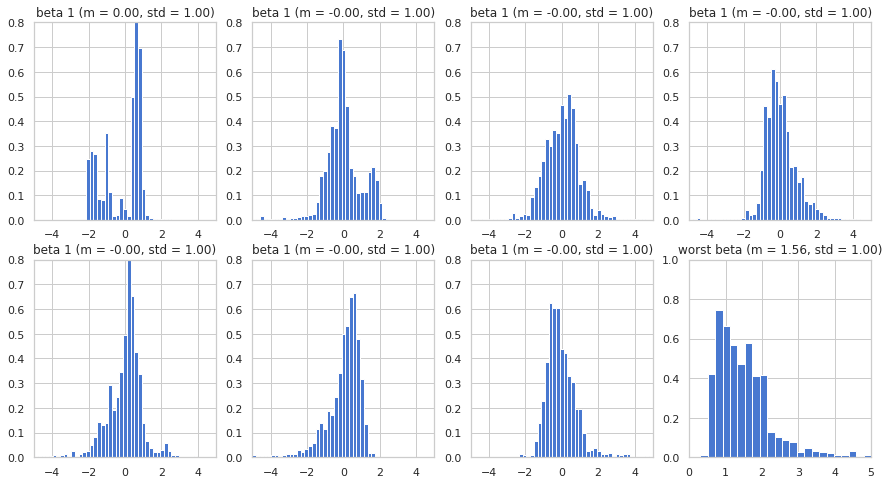

ind_rejection_sampling_T_0.005


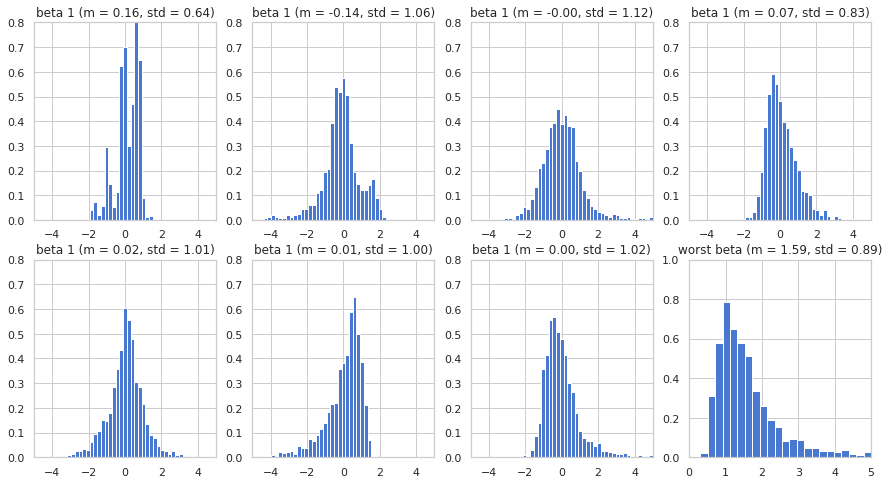

ind_rejection_sampling_T_0.1


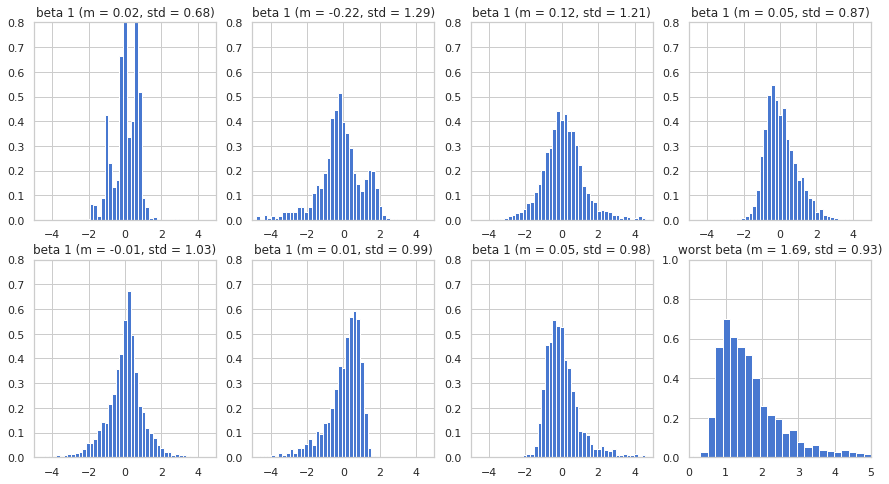

ind_rejection_sampling_T_10000


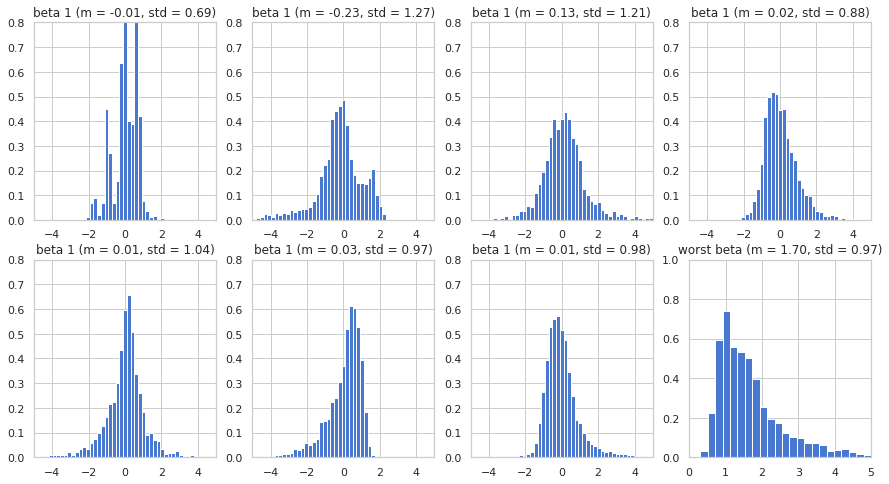

rbm_rejection_sampling_T_0.005


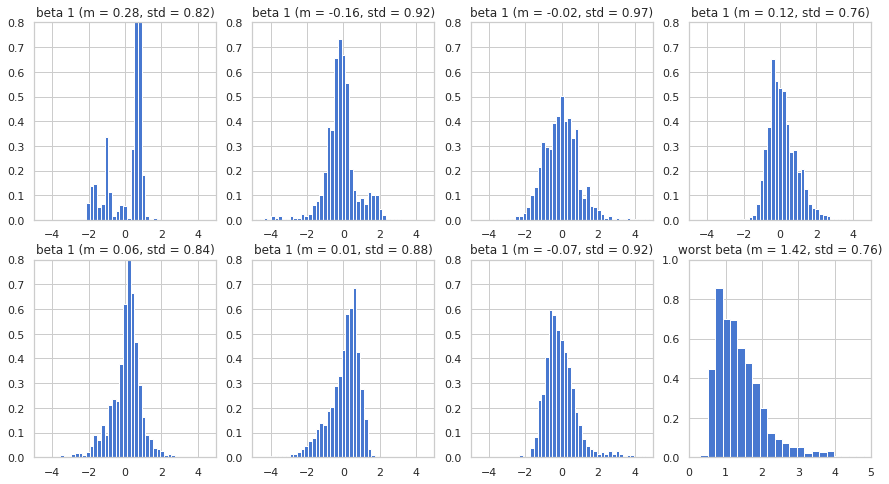

rbm_rejection_sampling_T_0.1


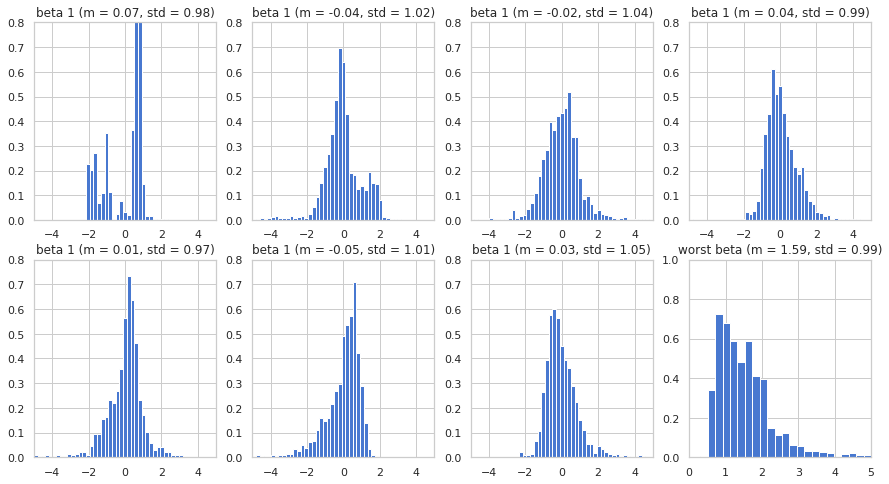

rbm_rejection_sampling_T_10000


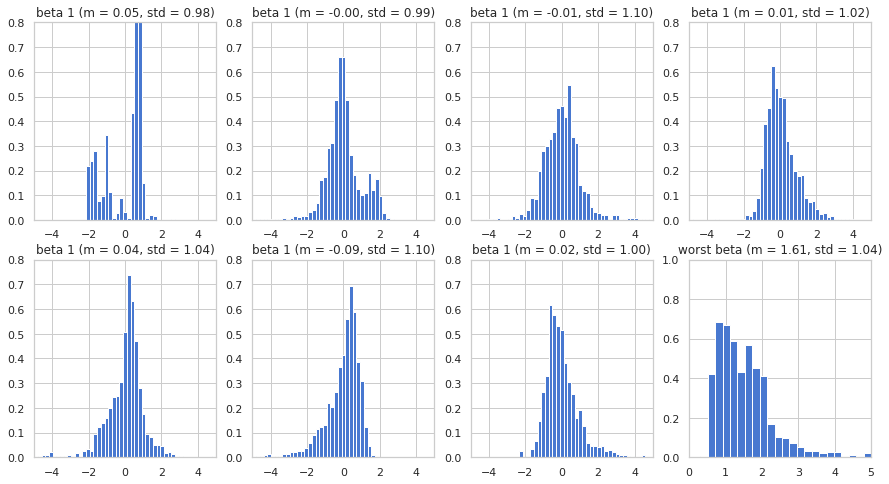

In [285]:
m, M = -5,5
x = np.linspace(m,M,50)
for i, file in enumerate(all_files):
    print(file)
    plt.figure(figsize = (15, 8))
    for j in range(7):
        plt.subplot(2, 4, j+1)
        plt.hist(X_n[i,:,j], bins = x, density=True)
        plt.title(f"beta 1 (m = {X_n[i,:,j].mean():.2f}, std = {X_n[i,:,j].std():.2f})")
        plt.xlim(m,M)
        plt.ylim(0, 0.8)
    
    
    plt.subplot(2, 4, 8)
    plt.hist(X_max[i,:], bins = x, density=True)
    plt.xlim(0,5)
    plt.ylim(0, 1.)
    plt.title(f"worst beta (m = {X_max[i,:].mean():.2f}, std = {X_max[i,:].std():.2f})")

    plt.show()

In [129]:
stds = np.zeros((len(all_files), 7, 6))
for i, x in enumerate(X_n):
    for j in range(6):
        stds[i, :, j] = (np.abs(x)>=j).mean(0)

(7, 2000, 7)

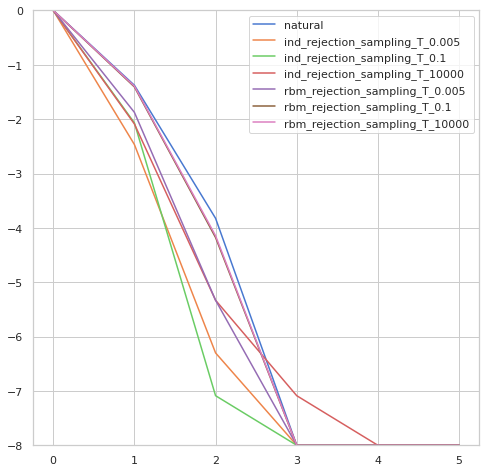

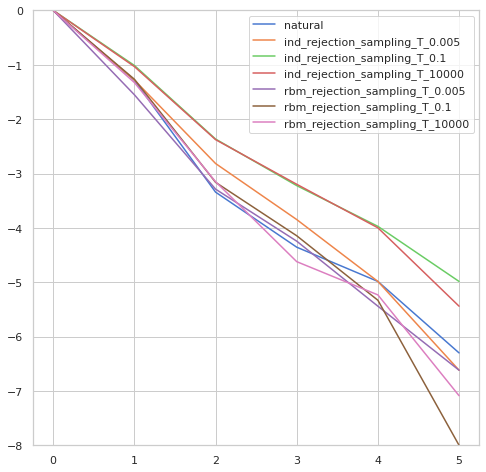

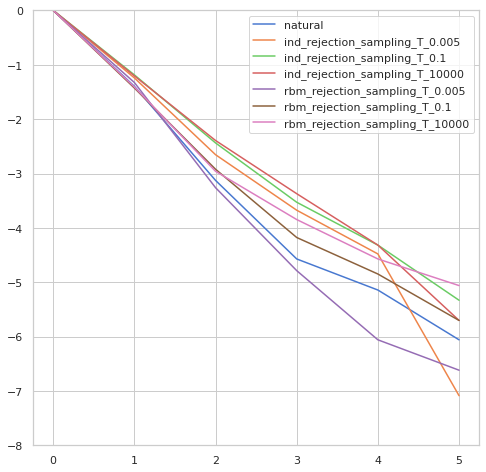

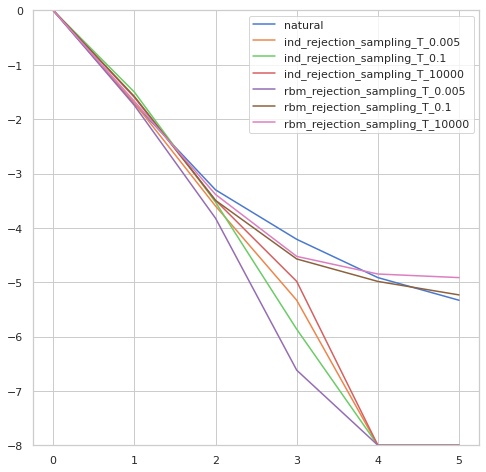

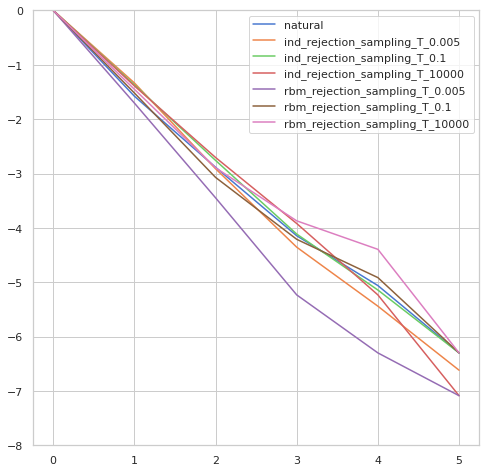

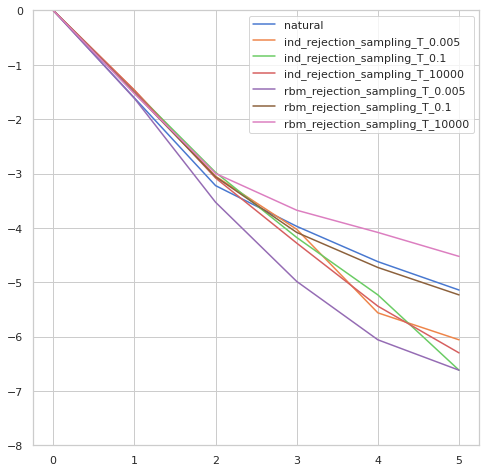

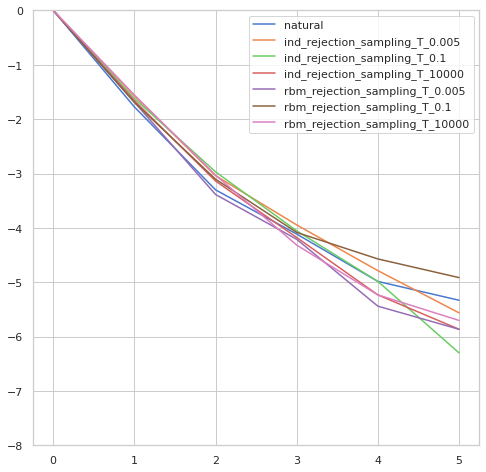

In [295]:
for i in range(7):
    plt.figure(figsize=(8,8))
    for s in stds:
        plt.plot(np.log(s[i]+np.exp(-8)))
        plt.ylim(-8, 0)
    plt.legend(all_files)
    plt.show()

### Max divergence

In [301]:
X_max = np.max(np.abs(X_n), 2)
x = np.linspace(0,5,100)
stds_max = np.zeros((len(all_files), len(x)))
for i, y in enumerate(X_max):
    for j, t in enumerate(x):
        stds_max[i, j] = (np.abs(y)>=t).mean()

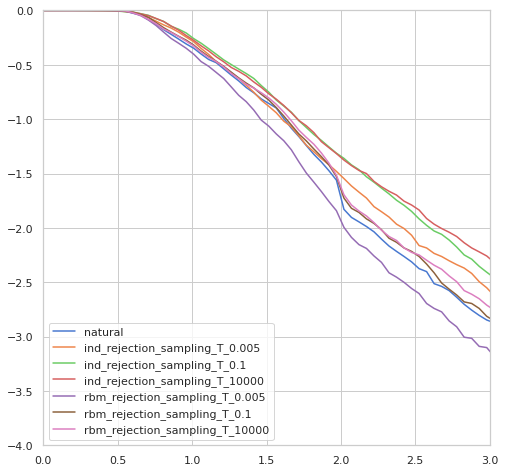

In [302]:
plt.figure(figsize=(8,8))
for s in stds_max:
    plt.plot(x, np.log(s+1e-28))
    plt.xlim(0,3)
    plt.ylim(-4, 0)
plt.legend(all_files)
plt.show()